In [3]:
!nvidia-smi

Fri Feb 24 05:18:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0  On |                    0 |
| N/A   36C    P0    60W / 300W |   5161MiB / 32505MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [4]:
import sys
sys.path.append('../')

In [5]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead
from models.head.classifier import LinearClassifier

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

from easydict import EasyDict as edict
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import nibabel as nib
from skimage.transform import resize

from copy import deepcopy

In [6]:
hashs =[("2022-07-02_08-00-31", "2022-07-03_13-41-32"),
        ("2022-07-02_08-00-57", "2022-07-03_13-37-29"),
        ("2022-07-02_09-38-52", "2022-07-03_13-33-23"),
        ("2022-07-02_09-40-42", "2022-07-03_13-29-10"),
        ("2022-07-02_11-17-38", "2022-07-03_13-25-05"),
        ("2022-07-02_11-20-21", "2022-07-03_13-21-00"),
        ("2022-07-02_17-15-14", "2022-07-03_13-16-54"),
        ("2022-07-02_17-15-34", "2022-07-03_13-12-44"),
        ("2022-07-02_18-53-46", "2022-07-03_13-08-35"),
        ("2022-07-02_18-54-27", "2022-07-03_13-04-32")]

In [14]:
gpus = ['1']
server = 'dgx'
hash = hashs[2]

In [27]:
logits = []
ys = []
mc_scores = []


#######################
config = edict()
config.server = server
config.gpus = gpus
local_rank = 0

config.finetune_file = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/ckpt.last.pth.tar')
finetune_config = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/configs.json')
with open(finetune_config, 'rb') as fb:
    finetune_config = json.load(fb)

finetune_config_names = [
    # data_parser
    'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
    'image_size', 'small_kernel', 'random_state',
    'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
    # model_parser
    'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
    'arch', 'no_max_pool',
    # train
    'batch_size',
    # moco / supmoco
    'alphas',
    # others
    'task', 'projector_dim'
]

for name in finetune_config_names:
    if name in finetune_config.keys():
        setattr(config, name, finetune_config[name])

#########################################
set_gpu(config)
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
torch.cuda.set_device(local_rank)

# Networks
if config.backbone_type == 'densenet':
    backbone = DenseNetBackbone(in_channels=1,
                                init_features=config.init_features,
                                growth_rate=config.growth_rate,
                                block_config=config.block_config,
                                bn_size=config.bn_size,
                                dropout_rate=config.dropout_rate,
                                semi=False)
    activation = True
elif config.backbone_type == 'resnet':
    backbone = build_resnet_backbone(arch=config.arch,
                                     no_max_pool=config.no_max_pool,
                                     in_channels=1,
                                     semi=False)
    activation = False
else:
    raise NotImplementedError

if config.small_kernel:
    backbone._fix_first_conv()

if config.crop:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
else:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
classifier = LinearClassifier(in_channels=out_dim, num_classes=2, activation=activation)

backbone.load_weights_from_checkpoint(path=config.finetune_file, key='backbone')
classifier.load_weights_from_checkpoint(path=config.finetune_file, key='classifier')

# load finetune data
data_processor = BrainProcessor(root=config.root,
                                data_info=config.data_info,
                                data_type=config.data_type,
                                mci_only=config.mci_only,
                                random_state=config.random_state)
datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

# intensity normalization
assert config.intensity in [None, 'scale', 'minmax']
mean_std, min_max = (None, None), (None, None)
if config.intensity is None:
    pass
elif config.intensity == 'scale':
    pass
elif config.intensity == 'minmax':
    with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
        minmax_stats = pickle.load(fb)
        min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
else:
    raise NotImplementedError

train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                  intensity=config.intensity,
                                                  min_max=min_max,
                                                  crop_size=config.crop_size,
                                                  rotate=config.rotate,
                                                  flip=config.flip,
                                                  affine=config.affine,
                                                  blur_std=config.blur_std,
                                                  prob=config.prob)

#########################################
train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=1, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=1, drop_last=False)

#########################
import pandas as pd
mc_table = pd.read_excel('/raidWorkspace/mingu/Data/ADNI/labels/AV45_FBP_SUVR.xlsx', sheet_name='list_id_SUVR_RSF')

########################
backbone.to(local_rank)
classifier.to(local_rank)

##
backbone.eval()
classifier.eval()
##
with torch.no_grad():
    for batch in test_loader:
        x = batch['x'].float().to(local_rank)
        y = batch['y'].long().to(local_rank)
        idx = batch['idx'].item()

        logit = classifier(backbone(x))

        # get MC score
        pet_id = test_set.pet[idx].split('/')[-1].replace('.pkl', '')
        mc_score = mc_table.loc[mc_table['ID'] == pet_id]['MC'].values

        logits.append(logit.detach().cpu().numpy())
        ys.append(y.cpu().numpy())
        mc_scores.append(mc_score)

## Check MC

### MC-score ~ Classification Probability

In [28]:
# correct = [np.argmax(logit) == y for logit, y in zip(logits, ys)]
# logits, ys, mc_scores = logits[correct], ys[correct], mc_scores[correct]

In [29]:
logits = np.concatenate(logits)
ys = np.concatenate(ys)
mc_scores = np.concatenate(mc_scores)

mc_scores = 53.6 * mc_scores - 43.2

y_pred = torch.tensor(logits).softmax(dim=1).numpy()

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(ys, y_pred[:, 1])
dist = fpr ** 2 + (1 - tpr) ** 2
threshold = thresholds[np.argmin(dist)]

In [31]:
threshold

0.34879407

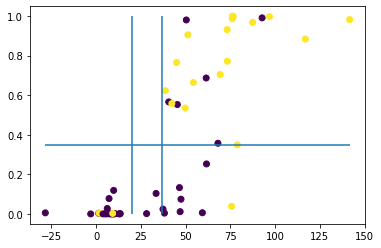

In [32]:
plt.scatter(mc_scores, y_pred[:, 1], c=ys)
plt.hlines(y=threshold, xmin=mc_scores.min(), xmax=mc_scores.max())
plt.vlines(x=20.0, ymin=y_pred[:, 1].min(), ymax=y_pred[:, 1].max())
plt.vlines(x=37.0, ymin=y_pred[:, 1].min(), ymax=y_pred[:, 1].max())
plt.show()

### MC-score ~ Uncertainty

## MC-only RF

In [33]:
from utils.metrics import classification_result

In [34]:
classification_result(y_true=ys, y_pred=torch.tensor(logits).softmax(dim=1).numpy(), adjusted=True)

{'acc': 0.7962962962962963,
 'auroc': 0.8647058823529412,
 'sens': 0.7999999959999999,
 'spec': 0.7941176447231834,
 'prec': 0.6956521708884688,
 'f1': 0.7441859932936755,
 'gmean': 0.7970533938213148}

In [ ]:
target_variables = ['MC']

In [36]:
y_train = []
mc_train = []
for batch in train_loader:
    y = batch['y'].numpy()
    idx = batch['idx'].item()
    
    # get MC score
    pet_id = train_set.pet[idx].split('/')[-1].replace('.pkl', '')
    mc_score = mc_table.loc[mc_table['ID'] == pet_id][target_variables].values
    
    #
    y_train.append(y)
    mc_train.append(mc_score)
y_train = np.array(y_train).reshape(-1, )
mc_train = np.array(mc_train)

In [42]:
y_test = []
mc_test = []
for batch in test_loader:
    y = batch['y'].numpy()
    idx = batch['idx'].item()
    
    # get MC score
    pet_id = test_set.pet[idx].split('/')[-1].replace('.pkl', '')
    mc_score = mc_table.loc[mc_table['ID'] == pet_id][target_variables].values
    
    #
    y_test.append(y)
    mc_test.append(mc_score)
y_test = np.array(y_test).reshape(-1, )
mc_test = np.array(mc_test)

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier()
rf.fit(mc_train, y_train)

RandomForestClassifier()

In [71]:
y_train_pred = rf.predict_proba(mc_train)
y_test_pred = rf.predict_proba(mc_test)

In [72]:
classification_result(y_true=y_test, y_pred=y_test_pred, adjusted=True)

{'acc': 0.6666666666666666,
 'auroc': 0.725735294117647,
 'sens': 0.64999999675,
 'spec': 0.6764705862456747,
 'prec': 0.5416666644097222,
 'f1': 0.5909090386363677,
 'gmean': 0.6631032188589941}

In [73]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred[:, 1])
dist = fpr ** 2 + (1 - tpr) ** 2
threshold = thresholds[np.argmin(dist)]

In [75]:
mc_test = 53.6 * mc_test - 43.2

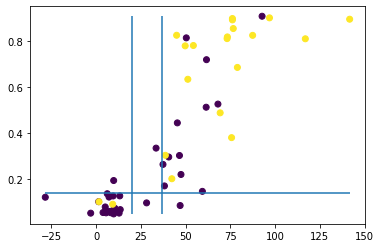

In [76]:
plt.scatter(mc_test, y_pred[:, 1], c=ys)
plt.hlines(y=threshold, xmin=mc_test.min(), xmax=mc_test.max())
plt.vlines(x=20.0, ymin=y_pred[:, 1].min(), ymax=y_pred[:, 1].max())
plt.vlines(x=37.0, ymin=y_pred[:, 1].min(), ymax=y_pred[:, 1].max())
plt.show()

# MC + Hippo Volume RF

In [7]:
hash = hashs[2]

In [24]:
result = []
for hash in hashs:
    #######################
    config = edict()
    config.server = server
    config.gpus = gpus
    local_rank = 0

    config.finetune_file = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/ckpt.last.pth.tar')
    finetune_config = os.path.join(f'../checkpoints/pet-supmoco/resnet/{hash[0]}/finetune/{hash[1]}/configs.json')
    with open(finetune_config, 'rb') as fb:
        finetune_config = json.load(fb)

    finetune_config_names = [
        # data_parser
        'data_type', 'root', 'data_info', 'mci_only', 'n_splits', 'n_cv',
        'image_size', 'small_kernel', 'random_state',
        'intensity', 'crop', 'crop_size', 'rotate', 'flip', 'affine', 'blur', 'blur_std', 'prob',
        # model_parser
        'backbone_type', 'init_features', 'growth_rate', 'block_config', 'bn_size', 'dropout_rate',
        'arch', 'no_max_pool',
        # train
        'batch_size',
        # moco / supmoco
        'alphas',
        # others
        'task', 'projector_dim'
    ]

    for name in finetune_config_names:
        if name in finetune_config.keys():
            setattr(config, name, finetune_config[name])

    #########################################
    set_gpu(config)
    np.random.seed(config.random_state)
    torch.manual_seed(config.random_state)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.allow_tf32 = True
    torch.cuda.set_device(local_rank)

    # Networks
    if config.backbone_type == 'densenet':
        backbone = DenseNetBackbone(in_channels=1,
                                    init_features=config.init_features,
                                    growth_rate=config.growth_rate,
                                    block_config=config.block_config,
                                    bn_size=config.bn_size,
                                    dropout_rate=config.dropout_rate,
                                    semi=False)
        activation = True
    elif config.backbone_type == 'resnet':
        backbone = build_resnet_backbone(arch=config.arch,
                                         no_max_pool=config.no_max_pool,
                                         in_channels=1,
                                         semi=False)
        activation = False
    else:
        raise NotImplementedError

    if config.small_kernel:
        backbone._fix_first_conv()

    if config.crop:
        out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
    else:
        out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
    classifier = LinearClassifier(in_channels=out_dim, num_classes=2, activation=activation)

    backbone.load_weights_from_checkpoint(path=config.finetune_file, key='backbone')
    classifier.load_weights_from_checkpoint(path=config.finetune_file, key='classifier')

    # load finetune data
    data_processor = BrainProcessor(root=config.root,
                                    data_info=config.data_info,
                                    data_type=config.data_type,
                                    mci_only=config.mci_only,
                                    random_state=config.random_state)
    datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

    # intensity normalization
    assert config.intensity in [None, 'scale', 'minmax']
    mean_std, min_max = (None, None), (None, None)
    if config.intensity is None:
        pass
    elif config.intensity == 'scale':
        pass
    elif config.intensity == 'minmax':
        with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
            minmax_stats = pickle.load(fb)
            min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
    else:
        raise NotImplementedError

    train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                      intensity=config.intensity,
                                                      min_max=min_max,
                                                      crop_size=config.crop_size,
                                                      rotate=config.rotate,
                                                      flip=config.flip,
                                                      affine=config.affine,
                                                      blur_std=config.blur_std,
                                                      prob=config.prob)

    #########################################
    train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
    test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

    train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
    test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)

    #########################
    train = {'y': [], 'mc': [], 'hippocampus': []}
    test = {'y': [], 'mc': [], 'hippocampus': []}

    import pandas as pd
    mc_table = pd.read_excel('/raidWorkspace/mingu/Data/ADNI/labels/AV45_FBP_SUVR.xlsx', sheet_name='list_id_SUVR_RSF')
    mri_table = pd.read_csv('/raidWorkspace/mingu/Data/ADNI/labels/MRI_BAI_features.csv')
    mri_table_filenames = mri_table['Filename'].str.split('/', expand=True).iloc[:, 1].values

    ########################
    backbone.to(local_rank)
    classifier.to(local_rank)

    with torch.no_grad():
        print(hash)
        for mode, dset, loader in zip(['train', 'test'], [train_set, test_set], [train_loader, test_loader]):
            for batch in tqdm.tqdm(loader):
                y = batch['y'].long().to(local_rank)
                if mode == 'train':
                    train['y'] += [batch['y'].detach().cpu().numpy()]
                else:
                    test['y'] += [batch['y'].detach().cpu().numpy()]


                idx = batch['idx'].cpu().numpy()        
                for i in idx:
                    mri_id = dset.mri[i].split('/')[-1].replace('.pkl', '')
                    pet_id = dset.pet[i].split('/')[-1].replace('.pkl', '')

                    # hippocampus volume            
                    temp = mri_table.iloc[np.where(mri_table_filenames == mri_id)[0].item(), :]
                    volume = temp['Left-Hippocampus'] + temp['Right-Hippocampus']

                    # NC
                    temp = mc_table.iloc[np.where(mc_table['ID'] == pet_id)[0].item(), :]
                    mc = temp['MC']
                    mc = 53.6 * mc - 43.2

                    if mode == 'train':
                        train['hippocampus'].append(volume)
                        train['mc'].append(mc)
                    else:
                        test['hippocampus'].append(volume)
                        test['mc'].append(mc)
    for k, v in train.items():
        try:
            train[k] = np.concatenate(v)
        except:
            train[k] = np.array(v)

    for k, v in test.items():
        try:
            test[k] = np.concatenate(v)
        except:
            test[k] = np.array(v)
    
    ##############
    from sklearn.ensemble import RandomForestClassifier
    from utils.metrics import classification_result
    
    rf = RandomForestClassifier()
    
    X_train = np.concatenate([train['hippocampus'].reshape(-1, 1), train['mc'].reshape(-1, 1)], axis=1)
    X_test = np.concatenate([test['hippocampus'].reshape(-1, 1), test['mc'].reshape(-1, 1)], axis=1)

    rf.fit(X_train, train['y'])
    y_test_pred = rf.predict_proba(X_test)
    result.append(classification_result(y_true=test['y'], y_pred=y_test_pred, adjusted=True))

('2022-07-02_08-00-31', '2022-07-03_13-41-32')


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


('2022-07-02_08-00-57', '2022-07-03_13-37-29')


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.12s/it]


('2022-07-02_09-38-52', '2022-07-03_13-33-23')


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.23s/it]


('2022-07-02_09-40-42', '2022-07-03_13-29-10')


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


('2022-07-02_11-17-38', '2022-07-03_13-25-05')


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


('2022-07-02_11-20-21', '2022-07-03_13-21-00')


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


('2022-07-02_17-15-14', '2022-07-03_13-16-54')


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.10s/it]


('2022-07-02_17-15-34', '2022-07-03_13-12-44')


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


('2022-07-02_18-53-46', '2022-07-03_13-08-35')


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.21s/it]


('2022-07-02_18-54-27', '2022-07-03_13-04-32')


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.25s/it]


In [26]:
for key in result[0].keys():    
    print(key, np.mean([res[key] for res in result]))

acc 0.7271146322023162
auroc 0.786232415948261
sens 0.7513499073388694
spec 0.7149183352750763
prec 0.4973952218291237
f1 0.5936757248107447
gmean 0.7303841723901645


[{'acc': 0.75,
  'auroc': 0.826829268292683,
  'sens': 0.7333333284444445,
  'spec': 0.7560975591314694,
  'prec': 0.5238095213151928,
  'f1': 0.6111110591049421,
  'gmean': 0.7446284574649298}]